# Intro

Ok so I started our *own* starter kernel here (really just a compilation of the ones on Kaggle) just to document what we've learned about the competition. 

A few notes on the competition:

-The **submission** for this competition is a dictionary of video_ids:segment_start_times per class label. So one column will be the different classes in the vocabulary file, and another column will contain a dictionary for each class.

-The 

A few notes on this notebook:

-The data is just the couple o

# Imports

In [25]:
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os

from IPython.display import YouTubeVideo
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE

# Just making sure we see what folder and files we're working with

In [5]:
print(os.getcwd())

/Users/arlomalmberg/Documents/Kaggle/YouTube


In [6]:
print(os.listdir('sample'))

['validate', '.DS_Store', 'vocabulary.csv', 'frame', 'sample_submission.csv']


In [8]:
print(os.listdir('sample/frame'))

['train01.tfrecord', 'train00.tfrecord']


# The little Kaggle sample contains *only* frame level records

In [58]:
# This one is a train record
frame_lvl_record = 'sample/frame/train00.tfrecord'

# It's items only contains keys(?- not sure what these are called) 'id' and 'labels'
vid_ids = []
labels = []

for example in tf.python_io.tf_record_iterator(frame_lvl_record):
    tf_example = tf.train.Example.FromString(example)
    vid_ids.append(tf_example.features.feature['id']
                   .bytes_list.value[0].decode(encoding='UTF-8'))
    labels.append(tf_example.features.feature['labels'].int64_list.value)

In [59]:
# One id per video
vid_ids[:5]

['op00', 'O900', 'Oq00', 'Li00', '1300']

In [60]:
# Multiple labels per video
labels[:5]

[[82, 103, 346, 350],
 [261, 1348],
 [15, 18, 67],
 [0, 1, 1768],
 [2, 17, 19, 30, 143]]

In [63]:
print(f'                  Number of videos in this tfrecord: {len(vid_ids)}')
print(f'Average number of labels per video in this tfrecord: {round(np.average([len(label) for label in labels]), 3)}')

                  Number of videos in this tfrecord: 1015
Average number of labels per video in this tfrecord: 3.002


In [71]:
# BUT they contain features- only rgb and audio

feat_rgb = []
feat_audio = []

for example in tf.python_io.tf_record_iterator(frame_lvl_record):  
    tf_seq_example = tf.train.SequenceExample.FromString(example)
    n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
    sess = tf.InteractiveSession()
    rgb_frame = []
    audio_frame = []
    # iterate through frames
    for i in range(n_frames):
        rgb_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['rgb']
                  .feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        audio_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['audio']
                  .feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        
        
    sess.close()
    
    feat_audio.append(audio_frame)
    feat_rgb.append(rgb_frame)
    break

In [90]:
# Looking at the first 5 rows of RGB data for the 0th video
feat_rgb[0][:5]

[array([179., 158., 143., ...,  14., 135., 123.], dtype=float32),
 array([201., 141., 141., ...,  49., 134.,  73.], dtype=float32),
 array([138., 169., 115., ...,  35., 215., 103.], dtype=float32),
 array([133., 173., 123., ...,  93., 152., 113.], dtype=float32),
 array([183., 165., 113., ...,  87., 180., 142.], dtype=float32)]

In [88]:
# Looking at the first 1 row of audio data for the 0th video
feat_audio[0][0]

array([119., 123., 161., 191., 220.,  35.,  73., 134., 126., 161., 162.,
       169.,  76., 115., 227., 161.,  92.,  60., 148., 119.,  53., 251.,
       133., 121., 165., 130., 200.,  85., 220., 218., 176., 163., 154.,
       137., 145.,  13., 110.,  42.,  86.,  82., 130., 135., 194., 240.,
       139.,  40.,  27., 111., 126.,  87., 118., 152., 192.,  53.,   0.,
       108.,  69., 219., 189.,   0., 195., 131.,  34., 255.,  45.,  44.,
        53., 136., 226., 228., 209., 185.,  51., 160., 255., 218., 130.,
       200.,  33.,  44., 255., 103., 143.,  34., 205., 152.,  86., 183.,
       172.,  41., 149., 205., 238., 220., 148., 153., 159.,  86., 102.,
       108., 114., 234., 180., 239., 169., 126., 115.,  40., 140., 215.,
        90.,   0., 170., 128., 179., 218.,  29.,  77., 103.,   0., 122.,
       114.,   0., 168., 186., 204., 190., 130.], dtype=float32)

In [91]:
print(f'The first video has {len(feat_rgb[0])} frames')
print(f'The every frame has {len(feat_rgb[0][0])} rgb values')
print(f'The every frame has {len(feat_audio[0][0])} audio values')

The first video has 234 frames
The every frame has 1024 rgb values
The every frame has 128 audio values


# Validate Records

In [21]:
validate_record = 'sample/validate/validate00.tfrecord'

In [22]:
val_vid_ids = []
val_vid_labels = []
segment_start_times = []
segment_end_times = []
segment_labels = []
segment_scores = []

for example in tf.python_io.tf_record_iterator(validate_record):
    tf_example = tf.train.Example.FromString(example)
    val_vid_ids.append(tf_example.features.feature['id']
                   .bytes_list.value[0].decode(encoding='UTF-8'))
    val_vid_labels.append(tf_example.features.feature['labels'].int64_list.value)
    segment_start_times.append(tf_example.features.feature['segment_start_times'].int64_list.value)
    segment_end_times.append(tf_example.features.feature['segment_end_times'].int64_list.value)
    segment_labels.append(tf_example.features.feature['segment_labels'].int64_list.value)
    segment_scores.append(tf_example.features.feature['segment_scores'].float_list.value)

In [23]:
print(val_vid_ids[0])
print(val_vid_labels[0])
print(segment_start_times[0])
print(segment_end_times[0])
print(segment_labels[0])
print(segment_scores[0])

Iv00
[375, 1036, 1062]
[145, 110, 135, 155, 70]
[150, 115, 140, 160, 75]
[1036, 1036, 1036, 1036, 1036]
[0.0, 0.0, 1.0, 0.0, 0.0]


In [36]:
rec_id = 5
print(val_vid_labels[rec_id])
print(segment_start_times[rec_id])
print(segment_labels[rec_id])
print(segment_scores[rec_id])

print('Picking a youtube video id:',vid_ids[rec_id])

[11, 20, 22, 123, 176, 211, 250, 728, 1672]
[110, 175, 150, 145, 100]
[1672, 1672, 1672, 1672, 1672]
[0.0, 1.0, 1.0, 1.0, 0.0]
Picking a youtube video id: gG00


In [38]:
vocabulary[vocabulary['Index']==1672]

,Index,TrainVideoCount,KnowledgeGraphId,Name,WikiUrl,Vertical1,Vertical2,Vertical3,WikiDescription
941,1672,547,/m/01tcjp,Muffin,https://en.wikipedia.org/wiki/Muffin,Food & Drink,NaN,NaN,"A muffin is an individual-sized, baked quick b..."


In [40]:
# let's read the video features (feat_rgb), 
# and the audio features while we're at it 
# (thanks again to earlier kernel providers)

feat_rgb = []
feat_audio = []

# the example that I started with read the first record and then did a break
# the continue statements at the beginning get us to the record of interest
# but then do the same thing - break after reading in the video feature data.
cur_rec = -1
for example in tf.python_io.tf_record_iterator(validate_record):
    cur_rec += 1
    if cur_rec < rec_id:
        continue
    tf_seq_example = tf.train.SequenceExample.FromString(example)
    n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
    sess = tf.InteractiveSession()
    rgb_frame = []
    audio_frame = []
    # iterate through frames
    for i in range(n_frames):
        rgb_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['rgb']
                  .feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        audio_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['audio']
                  .feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        
        
    sess.close()
    
    feat_audio.append(audio_frame)
    feat_rgb.append(rgb_frame)
    break
print('The video has %d frames' %len(feat_rgb[0]))

The video has 211 frames


In [41]:
# from here on out we'll switch to exploration in numpy
# which I am more familiar with
# first, we'll convert the rgb_frame values into a numpy array
rgb_frame = np.array(rgb_frame)
# the numpy array has the shape: (num frames, 1024)
# where 1024 is the number of abstract "features" output by a neural network
rgb_frame.shape

(211, 1024)

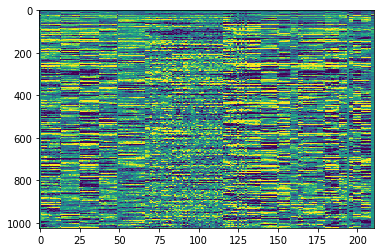

In [42]:
# let's take a look at these abstracted features:
# the x-axis is time in seconds, the y-axis is the list of features
plt.imshow(rgb_frame.T, aspect='auto')

# Explore vocab

In [105]:
vocab = pd.read_csv('sample/vocabulary.csv')
print(f'We have {len(vocab["Index"].unique())} unique labels in the dataset')
print(f'We have {len(np.hstack([vocab["Vertical1"].unique(), vocab["Vertical2"].unique(), vocab["Vertical3"].unique()]))} unique categories in the dataset')
print('And 3 "Verticals" or groups of categories')

We have 1000 unique labels in the dataset
We have 50 unique categories in the dataset
And 3 "Verticals" or groups of categories


In [96]:
# Note the column TrainVideoCount
vocabulary.head()

,Index,TrainVideoCount,KnowledgeGraphId,Name,WikiUrl,Vertical1,Vertical2,Vertical3,WikiDescription
0,3,378135,/m/01jddz,Concert,https://en.wikipedia.org/wiki/Concert,Arts & Entertainment,NaN,NaN,A concert is a live music performance in front...
1,7,200813,/m/0k4j,Car,https://en.wikipedia.org/wiki/Car,Autos & Vehicles,NaN,NaN,"A car is a wheeled, self-powered motor vehicle..."
2,8,181579,/m/026bk,Dance,https://en.wikipedia.org/wiki/Dance,Arts & Entertainment,NaN,NaN,Dance is a performance art form consisting of ...
3,11,135357,/m/02wbm,Food,https://en.wikipedia.org/wiki/Food,Food & Drink,NaN,NaN,Food is any substance consumed to provide nutr...
4,12,130835,/m/02vx4,Association football,https://en.wikipedia.org/wiki/Association_foot...,Sports,NaN,NaN,"Association football, more commonly known as f..."


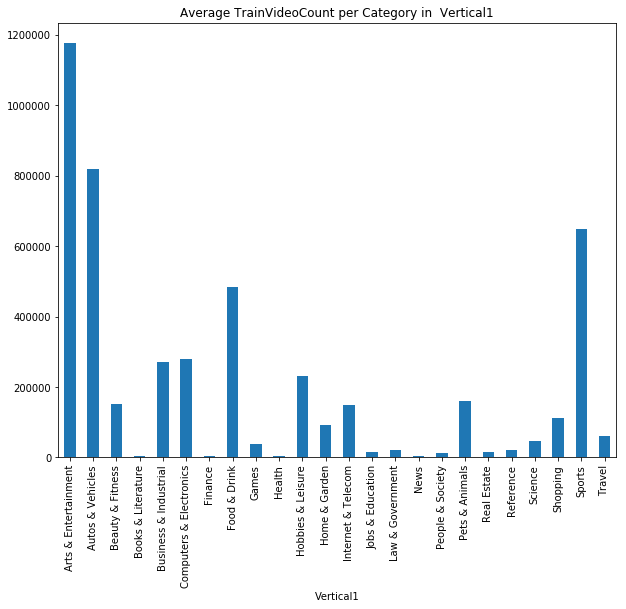

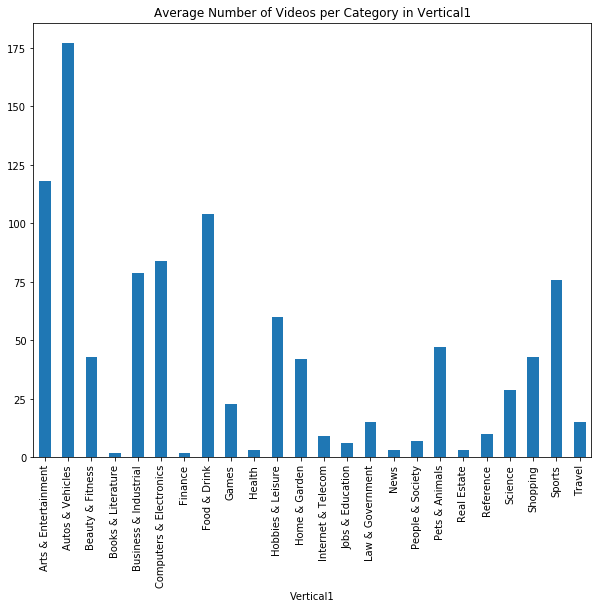

In [112]:
plt.figure(figsize = (10,8))
vocabulary.groupby('Vertical1').TrainVideoCount.sum().plot(kind="bar")
plt.title("Average TrainVideoCount per Category in  Vertical1")
plt.show()

plt.figure(figsize = (10,8))
vocabulary.groupby('Vertical1').size().plot(kind="bar")
plt.title("Average Number of Videos per Category in Vertical1")
plt.show()

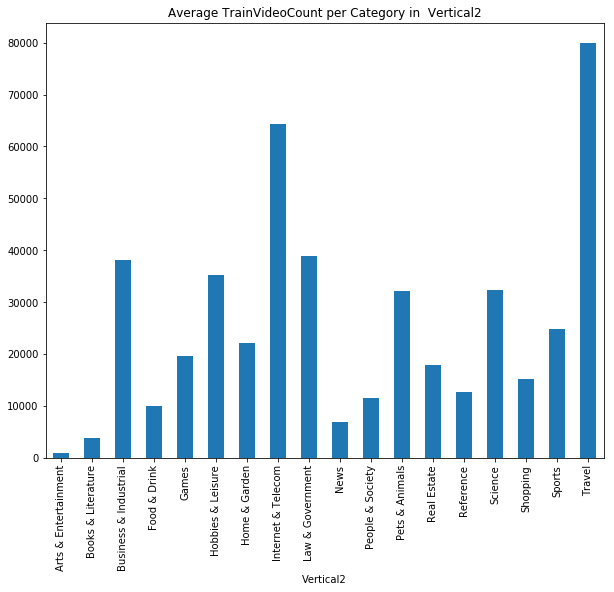

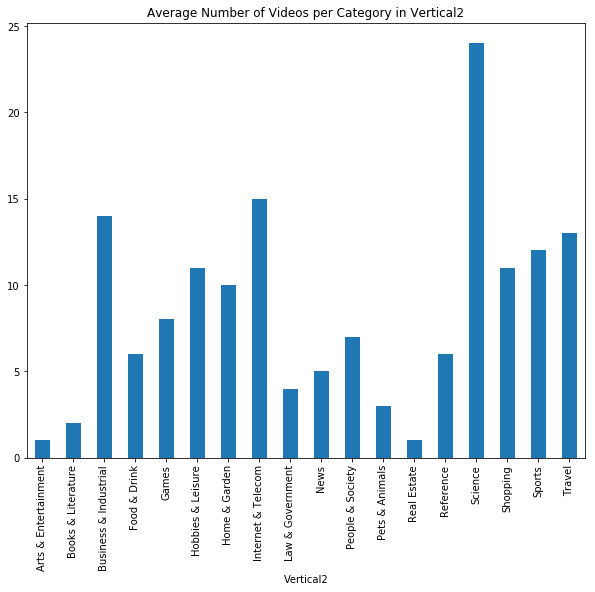

In [111]:
plt.figure(figsize = (10,8))
vocabulary.groupby('Vertical2').TrainVideoCount.sum().plot(kind="bar")
plt.title("Average TrainVideoCount per Category in  Vertical2")
plt.show()

plt.figure(figsize = (10,8))
vocabulary.groupby('Vertical2').Index.count().plot(kind="bar")
plt.title("Average Number of Videos per Category in Vertical2")
plt.show()

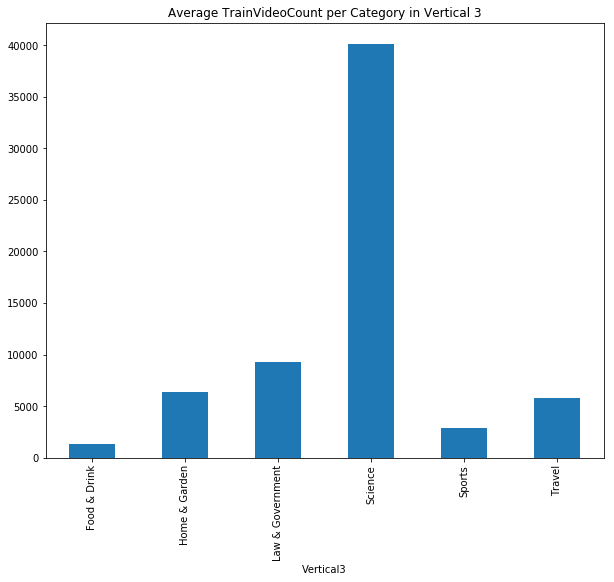

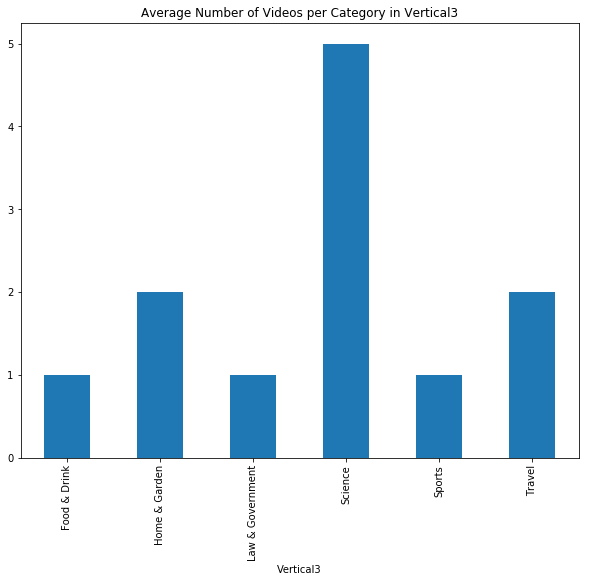

In [109]:
plt.figure(figsize = (10,8))
vocabulary.groupby('Vertical3').TrainVideoCount.sum().plot(kind="bar")
plt.title("Average TrainVideoCount per Category in Vertical 3")
plt.show()

plt.figure(figsize = (10,8))
vocabulary.groupby('Vertical3').Index.count().plot(kind="bar")
plt.title("Average Number of Videos per Category in Vertical3")
plt.show()